
# Slide 10 — Word-vector diagram from **model embeddings** (PCA → vector PDF)

This notebook recreates the two-panel figure on **page 10** of your slides (gender direction in blue, plural in red), but instead of hand-placed points it:

1. **Embeds** the 8 words with a model (CLIP or BERT).
2. **Projects** to 2D via PCA.
3. **Draws** the two panels with arrows, ensuring **labels aren’t occluded** (white text bboxes + arrows clipped to the label box).
4. **Saves** a *vector* PDF (and a PNG preview if desired).

Models supported here:
- **CLIP** (via `open-clip-torch`, default: `ViT-B-32 / laion2b_s34b_b79k`)
- **BERT** (via `transformers`, default: `bert-base-uncased`)



In [9]:

# If running fresh, uncomment to install deps.
%pip install open-clip-torch transformers scikit-learn matplotlib torch --quiet


Note: you may need to restart the kernel to use updated packages.


In [10]:

import os, math, numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
import torch

WORDS = ["KING","QUEEN","MAN","WOMAN","UNCLE","AUNT","KINGS","QUEENS"]

# ------------------ Embeddings ------------------
def embed_clip(words, clip_model="ViT-B-32", pretrained="laion2b_s34b_b79k", device=None):
    import open_clip
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model, _, preprocess = open_clip.create_model_and_transforms(clip_model, pretrained=pretrained, device=device)
    tokenizer = open_clip.get_tokenizer(clip_model)
    with torch.no_grad():
        tok = tokenizer([w.lower() for w in words]).to(device)
        feats = model.encode_text(tok).float()
        feats = feats / (feats.norm(dim=-1, keepdim=True) + 1e-8)
    return feats.cpu().numpy()

def embed_bert(words, bert_model="bert-base-uncased", device=None):
    from transformers import AutoTokenizer, AutoModel
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    tok = AutoTokenizer.from_pretrained(bert_model)
    mdl = AutoModel.from_pretrained(bert_model).to(device).eval()
    # Tokenize each word as a separate "sequence"
    enc = tok([w.lower() for w in words], return_tensors="pt", padding=True, truncation=True, add_special_tokens=True)
    enc = {k: v.to(device) for k,v in enc.items()}
    with torch.no_grad():
        out = mdl(**enc)  # last_hidden_state: [B, T, H]
    last = out.last_hidden_state  # [B, T, H]
    # Average over non-special tokens
    ids = enc["input_ids"]
    special = set([tok.cls_token_id, tok.sep_token_id, tok.pad_token_id])
    masks = torch.ones_like(ids, dtype=torch.bool)
    for s in special:
        if s is None: 
            continue
        masks &= (ids != s)
    masks = masks & (ids != tok.pad_token_id)
    masks = masks.to(device)
    sums = (last * masks.unsqueeze(-1)).sum(dim=1)
    counts = masks.sum(dim=1).clamp(min=1).unsqueeze(-1)
    feats = sums / counts
    feats = feats / (feats.norm(dim=-1, keepdim=True) + 1e-8)
    return feats.detach().cpu().numpy()

# ------------------ PCA ------------------
def pca_2d(X):
    # X: [N, D] -> [N, 2]
    X = np.asarray(X, dtype=np.float64)
    Xc = X - X.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    Y = Xc @ Vt[:2].T
    return Y

# ------------------ Geometry helpers ------------------
def normalize_coords(X, pad=0.08):
    # Map to [pad, 1-pad] x [pad, 1-pad]
    X = np.asarray(X, dtype=float)
    minx, miny = X[:,0].min(), X[:,1].min()
    maxx, maxy = X[:,0].max(), X[:,1].max()
    w, h = (maxx - minx) + 1e-9, (maxy - miny) + 1e-9
    Xn = np.empty_like(X)
    Xn[:,0] = (X[:,0] - minx) / w
    Xn[:,1] = (X[:,1] - miny) / h
    Xn = pad + Xn * (1 - 2*pad)
    return Xn

def map_to_rect(X01, rect):
    # X01 in [0,1]^2 -> map into rect=(x0,y0,x1,y1) in axes coords
    x0, y0, x1, y1 = rect
    out = np.empty_like(X01)
    out[:,0] = x0 + X01[:,0] * (x1 - x0)
    out[:,1] = y0 + X01[:,1] * (y1 - y0)
    return out

def liang_barsky_clip(p0, p1, rect):
    # p0, p1 in display coords; rect = (x0,y0,x1,y1) in display coords
    (x0, y0, x1, y1) = rect
    dx, dy = p1[0] - p0[0], p1[1] - p0[1]
    p = [-dx, dx, -dy, dy]
    q = [p0[0]-x0, x1-p0[0], p0[1]-y0, y1-p0[1]]
    u1, u2 = 0.0, 1.0
    for pi, qi in zip(p, q):
        if abs(pi) < 1e-12:
            if qi < 0:
                return None
        else:
            t = qi / pi
            if pi < 0:
                if t > u2: return None
                if t > u1: u1 = t
            else:
                if t < u1: return None
                if t < u2: u2 = t
    return (u1, u2)

# ------------------ Drawing ------------------
BLUE = "#346FC1"
RED  = "#CC3434"
BOX  = "#87AAC8"

LEFT_RECT  = (0.05, 0.1, 0.48, 0.95)
RIGHT_RECT = (0.52, 0.1, 0.95, 0.95)

def draw_panel_pdf(positions, words, out_pdf_path, title=None):
    # Single-axes canvas with two rectangles (no subplots).
    fig = plt.figure(figsize=(12.5, 5.0), dpi=150)
    ax = fig.add_axes([0,0,1,1])
    ax.set_xlim(0,1); ax.set_ylim(0,1); ax.axis("off")
    # Panels
    for rect in (LEFT_RECT, RIGHT_RECT):
        ax.add_patch(Rectangle((rect[0], rect[1]), rect[2]-rect[0], rect[3]-rect[1], fill=False, ec=BOX, lw=2))

    word_to_xy = {w: positions[i] for i,w in enumerate(words)}

    # Set up subsets
    left_words  = ["KING","QUEEN","MAN","WOMAN","UNCLE","AUNT"]
    right_words = ["KING","QUEEN","KINGS","QUEENS"]

    # Draw texts first (so we can get their bboxes) — place in both panels using same normalized coords.
    txts = {}
    renderer = fig.canvas.get_renderer()
    def draw_text_for_panel(name, panel_rect):
        x, y = word_to_xy[name]
        # Map normalized (0..1) coords into panel rect
        xm = panel_rect[0] + x * (panel_rect[2] - panel_rect[0])
        ym = panel_rect[1] + y * (panel_rect[3] - panel_rect[1])
        t = ax.text(xm, ym, name, fontsize=16, fontweight="bold", ha="center", va="center",
                    zorder=5, bbox=dict(facecolor="white", edgecolor="white", boxstyle="round,pad=0.22"))
        return t

    left_txts  = {w: draw_text_for_panel(w, LEFT_RECT)  for w in left_words}
    right_txts = {w: draw_text_for_panel(w, RIGHT_RECT) for w in right_words}

    fig.canvas.draw()  # ensure text bboxes exist

    # Helper: draw clipped arrow from A to label of B
    def draw_arrow_to_label(A_word, B_word, color, panel_rect, lw=2.5):
        # data positions -> panel positions in axes coords
        Ax, Ay = word_to_xy[A_word]
        Bx, By = word_to_xy[B_word]
        Ax = panel_rect[0] + Ax * (panel_rect[2] - panel_rect[0])
        Ay = panel_rect[1] + Ay * (panel_rect[3] - panel_rect[1])
        Bx = panel_rect[0] + Bx * (panel_rect[2] - panel_rect[0])
        By = panel_rect[1] + By * (panel_rect[3] - panel_rect[1])

        # Transform to display coords for clipping
        start_disp = ax.transData.transform((Ax, Ay))
        end_disp   = ax.transData.transform((Bx, By))

        # Get label bbox (in display coords), expand slightly
        txt = (left_txts if panel_rect==LEFT_RECT else right_txts)[B_word]
        bb  = txt.get_window_extent(renderer=fig.canvas.get_renderer()).expanded(1.05, 1.20)
        rect_disp = (bb.x0, bb.y0, bb.x1, bb.y1)

        # Clip the line segment to stop at the label bbox edge
        res = liang_barsky_clip(start_disp, end_disp, rect_disp)
        if res is not None:
            u1, _ = res   # entering parameter
            eps = 2.0     # retreat a few pixels to avoid touching the box
            # intersection point in display coords:
            ix = start_disp[0] + u1 * (end_disp[0] - start_disp[0])
            iy = start_disp[1] + u1 * (end_disp[1] - start_disp[1])
            # retreat along the direction by eps
            vx, vy = end_disp[0] - start_disp[0], end_disp[1] - start_disp[1]
            vlen = (vx*vx + vy*vy)**0.5 + 1e-9
            ix -= eps * (vx / vlen); iy -= eps * (vy / vlen)
            end_disp = (ix, iy)

        # Back to data coords
        end_data = ax.transData.inverted().transform(end_disp)

        # Draw arrow
        arr = FancyArrowPatch((Ax, Ay), end_data, arrowstyle="-|>", mutation_scale=12,
                              lw=lw, color=color, zorder=3, shrinkA=0, shrinkB=0, clip_on=False)
        ax.add_patch(arr)

    # Arrows: left (gender, BLUE)
    draw_arrow_to_label("KING",  "QUEEN",  BLUE, LEFT_RECT)
    draw_arrow_to_label("MAN",   "WOMAN",  BLUE, LEFT_RECT)
    draw_arrow_to_label("UNCLE", "AUNT",   BLUE, LEFT_RECT)

    # Right: blue gender + red plural
    draw_arrow_to_label("KING",  "QUEEN",  BLUE, RIGHT_RECT)
    draw_arrow_to_label("KING",  "KINGS",  RED,  RIGHT_RECT)
    draw_arrow_to_label("QUEEN", "QUEENS", RED,  RIGHT_RECT)

    if title:
        ax.text(0.5, 0.02, title, ha="center", va="center", fontsize=13)

    # Save vector PDF (and also return fig in case user wants PNG)
    os.makedirs(os.path.dirname(out_pdf_path), exist_ok=True)
    fig.savefig(out_pdf_path, format="pdf", bbox_inches="tight")
    plt.close(fig)
    return out_pdf_path

def make_slide10_for_model(model_kind="clip",
                           clip_model="ViT-B-32", clip_ckpt="laion2b_s34b_b79k",
                           bert_model="bert-base-uncased",
                           out_pdf="slide10_clip.pdf"):
    if model_kind.lower() == "clip":
        X = embed_clip(WORDS, clip_model, clip_ckpt)
        title = f"CLIP ({clip_model}, {clip_ckpt})"
    elif model_kind.lower() == "bert":
        X = embed_bert(WORDS, bert_model)
        title = f"BERT ({bert_model})"
    else:
        raise ValueError("model_kind must be 'clip' or 'bert'")
    Y = pca_2d(X)
    Yn = normalize_coords(Y, pad=0.10)  # stay well clear of the panel borders
    # Single axes canvas expects normalized coords in [0,1]; draw_panel maps those into panels.
    # Here we pass Yn directly; draw_panel maps again into L/R rects.
    positions = Yn
    return draw_panel_pdf(positions, WORDS, out_pdf, title=title)

print("Helpers loaded. Run the next cell to generate both PDFs.")


Helpers loaded. Run the next cell to generate both PDFs.


In [11]:
# --- Add SVG export helpers (re-uses your existing embedding + plotting code) ---

def draw_panel_svg(positions, words, out_svg_path, title=None):
    import os
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle, FancyArrowPatch
    import numpy as np

    # same constants as before
    BLUE = "#346FC1"; RED = "#CC3434"; BOX = "#87AAC8"
    LEFT_RECT  = (0.05, 0.1, 0.48, 0.95)
    RIGHT_RECT = (0.52, 0.1, 0.95, 0.95)

    fig = plt.figure(figsize=(12.5, 5.0), dpi=150)
    ax = fig.add_axes([0,0,1,1]); ax.set_xlim(0,1); ax.set_ylim(0,1); ax.axis("off")
    for rect in (LEFT_RECT, RIGHT_RECT):
        ax.add_patch(Rectangle((rect[0], rect[1]), rect[2]-rect[0], rect[3]-rect[1], fill=False, ec=BOX, lw=2))

    word_to_xy = {w: positions[i] for i,w in enumerate(words)}
    left_words  = ["KING","QUEEN","MAN","WOMAN","UNCLE","AUNT"]
    right_words = ["KING","QUEEN","KINGS","QUEENS"]

    # draw labels with white bboxes so arrows never obscure them
    def draw_text(name, panel_rect):
        x, y = word_to_xy[name]
        xm = panel_rect[0] + x * (panel_rect[2] - panel_rect[0])
        ym = panel_rect[1] + y * (panel_rect[3] - panel_rect[1])
        return ax.text(xm, ym, name, fontsize=16, fontweight="bold", ha="center", va="center",
                       zorder=5, bbox=dict(facecolor="white", edgecolor="white", boxstyle="round,pad=0.22"))

    left_txts  = {w: draw_text(w, LEFT_RECT)  for w in left_words}
    right_txts = {w: draw_text(w, RIGHT_RECT) for w in right_words}
    fig.canvas.draw()  # ensure label bboxes exist

    # simple arrow (we keep it behind text; label bboxes already occlude lines)
    def arrow(A, B, color, panel_rect):
        Ax, Ay = word_to_xy[A]; Bx, By = word_to_xy[B]
        Ax = panel_rect[0] + Ax * (panel_rect[2] - panel_rect[0])
        Ay = panel_rect[1] + Ay * (panel_rect[3] - panel_rect[1])
        Bx = panel_rect[0] + Bx * (panel_rect[2] - panel_rect[0])
        By = panel_rect[1] + By * (panel_rect[3] - panel_rect[1])
        ax.add_patch(FancyArrowPatch((Ax, Ay), (Bx, By), arrowstyle="-|>", mutation_scale=12,
                                     lw=2.5, color=color, zorder=3, shrinkA=0, shrinkB=0, clip_on=False))

    # left panel: gender (blue)
    arrow("KING",  "QUEEN",  BLUE, LEFT_RECT)
    arrow("MAN",   "WOMAN",  BLUE, LEFT_RECT)
    arrow("UNCLE", "AUNT",   BLUE, LEFT_RECT)
    # right panel: gender (blue) + plural (red)
    arrow("KING",  "QUEEN",  BLUE, RIGHT_RECT)
    arrow("KING",  "KINGS",  RED,  RIGHT_RECT)
    arrow("QUEEN", "QUEENS", RED,  RIGHT_RECT)

    if title:
        ax.text(0.5, 0.02, title, ha="center", va="center", fontsize=13)
    os.makedirs(os.path.dirname(out_svg_path), exist_ok=True)
    fig.savefig(out_svg_path, format="svg", bbox_inches="tight")
    plt.close(fig)
    return out_svg_path

def make_slide10_svg(model_kind="clip",
                     clip_model="ViT-B-32", clip_ckpt="laion2b_s34b_b79k",
                     bert_model="bert-base-uncased",
                     out_svg="assets/outputs/slide10_clip.svg"):
    # reuse your embed_* and pca_2d + normalize_coords helpers
    words = ["KING","QUEEN","MAN","WOMAN","UNCLE","AUNT","KINGS","QUEENS"]
    if model_kind.lower() == "clip":
        X = embed_clip(words, clip_model, clip_ckpt); title = f"CLIP ({clip_model}, {clip_ckpt})"
    else:
        X = embed_bert(words, bert_model);           title = f"BERT ({bert_model})"
    Y  = pca_2d(X); Yn = normalize_coords(Y, pad=0.10)
    return draw_panel_svg(Yn, words, out_svg, title=title)


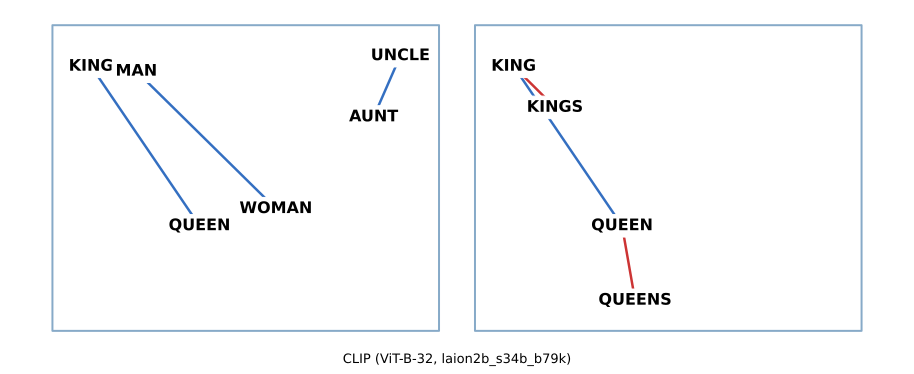

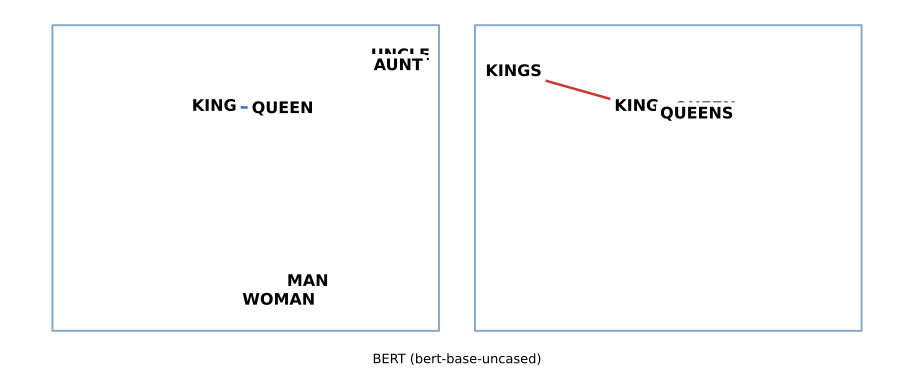

In [12]:
# Assuming you still have the helpers from the notebook I gave you:
clip_svg = make_slide10_svg("clip", out_svg="assets/outputs/slide10_clip.svg")
bert_svg = make_slide10_svg("bert", out_svg="assets/outputs/slide10_bert.svg")

from IPython.display import SVG, display
display(SVG(filename=clip_svg))
display(SVG(filename=bert_svg))

